# Simulation of ion motion in a linear ion trap

This application is used to calculate the motion of a single ion in a linear quadrupole ion trap

## Imports

In [1]:
from math import pi
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import mpld3

mpld3.enable_notebook()

from mpl_toolkits.axes_grid1 import make_axes_locatable

## Setting up constants

In [2]:
avagadros = 6.0221409*10**23
default_frequency = 0.8
default_radius = .004
electron_charge = -1.602*10**-19

## Calculate RF voltage

In [3]:
def calculate_RF_voltage(q_value, mass_charge_ratio = 500, frequency_Mhz = default_frequency, radius = default_radius):
    freq = 2 * pi * frequency_Mhz * 1000000
    electron = electron_charge
    mass_kg = calculate_mass(mass_charge_ratio)
    RF_voltage = (q_value*mass_kg*(freq**2)*(radius**2))/(4*electron)
    return RF_voltage

## Calculate Q value

In [4]:
def calculate_q_value(RF_voltage, mass_charge_ratio = 500, frequency_Mhz = default_frequency, radius = default_radius):
    freq = 2 * pi * frequency_Mhz * 1000000
    electron = electron_charge
    mass_kg = calculate_mass(mass_charge_ratio)
    q_value = (4*electron*RF_voltage)/(mass_kg*(freq**2)*(radius**2))
    return q_value

## Calculate DC voltage

In [5]:
def calculate_DC_voltage(a_value, mass_charge_ratio = 500, frequency_Mhz = default_frequency, radius = default_radius):
    freq = 2 * pi * frequency_Mhz * 1000000
    electron = electron_charge
    mass_kg = calculate_mass(mass_charge_ratio)
    DC_voltage = (a_value*mass_kg*(freq**2)*(radius**2))/(8*electron)
    return DC_voltage

## Calculate A value

In [6]:
def calculate_a_value(DC_voltage, mass_charge_ratio = 500, frequency_Mhz = default_frequency, radius = default_radius):
    freq = 2 * pi * frequency_Mhz * 1000000
    electron = electron_charge
    mass_kg = calculate_mass(mass_charge_ratio)
    a_value = (8*electron*DC_voltage)/(mass_kg*(freq**2)*(radius**2))
    return a_value

## Calculate mass

In [7]:
def calculate_mass(mass_charge_ratio, charge_number=1):
    mass_kg = (mass_charge_ratio*charge_number)/(avagadros*1000)
    return mass_kg

## Calculate position

In [8]:
def calculate_motion(initial_x_position,initial_y_position,a,q,mass_charge_ratio,step_size,duration,flag_unstable=False,magnetic_field=False,B=1.4,theta=pi/2,*optional_arguments):
    unstable_motion = False         
    x_motion_array = np.array([initial_x_position])   
    y_motion_array = np.array([initial_y_position])   
    mass_kg = calculate_mass(mass_charge_ratio)
    RF_voltage = calculate_RF_voltage(q,mass_charge_ratio)
    DC_voltage = calculate_DC_voltage(a,mass_charge_ratio)
    current_velocity_in_x = 0                 
    current_velocity_in_y = 0             
    current_x_position = initial_x_position
    current_y_position = initial_y_position    
                                    
    time_steps = np.array([x for x in np.arange(step_size,duration,step_size)])
    print('RF Voltage(V) is: {}v'.format(RF_voltage))
    print('DC Voltage(U) is: {}v'.format(DC_voltage))

    for current_time in time_steps:
        force_in_x_direction = fx_trap(mass_charge_ratio,current_time,current_x_position,RF_voltage,DC_voltage)
        
        if magnetic_field == True:
            f_mag_x = magnetic_force(electron_charge,current_velocity_in_x,B,theta)
            force_in_x_direction += f_mag_x
        
        acceleration_in_x_direction = force_in_x_direction/mass_kg
        current_velocity_in_x += acceleration_in_x_direction*step_size
        current_x_position += current_velocity_in_x*step_size
        x_motion_array = np.append(x_motion_array, current_x_position)
            
        force_in_y_direction = fy_trap(mass_charge_ratio,current_time,current_y_position,RF_voltage,DC_voltage)
        
        if magnetic_field == True:
            f_mag_y = magnetic_force(electron_charge,current_velocity_in_y,B,theta)
            force_in_y_direction += f_mag_y
        
        acceleration_in_y_direction = force_in_y_direction/mass_kg
        current_velocity_in_y += acceleration_in_y_direction*step_size
        current_y_position += current_velocity_in_y*step_size
        y_motion_array = np.append(y_motion_array, current_y_position)
        
        if flag_unstable:
            if abs(current_x_position) > default_radius * 1000 or abs(current_y_position) > default_radius * 1000:
                time_steps = np.array([x for x in np.arange(step_size,current_time+(2*step_size),step_size)])
                print("ION MOTION IS NOT STABLE")
                unstable_motion = True
                break

    fig, (ax1, ax2, comb) = plt.subplots(3)
    fig2, ax3 = plt.subplots(1)
    if unstable_motion == False:    
        time_steps = np.append(time_steps, duration)
    ax1.plot(time_steps,x_motion_array,'r-')
    ax2.plot(time_steps,y_motion_array)
    comb.plot(time_steps,x_motion_array,'r-',time_steps,y_motion_array)
    ax3.plot(x_motion_array,y_motion_array)
    ax3.set(xlim=(-4,4),ylim=(-4,4))
    fig.suptitle('Position vs Time')
    fig2.suptitle('X-Y Plot')

## Calculate force in the X direction

In [9]:
def fx_trap(mass_charge_ratio,t,x,v,u):
    freq = 2 * pi * default_frequency * 1000000
    r = default_radius
    electron = electron_charge
    x_pos = x
    f = -(2*electron*(v*math.cos(freq*t) + u)*x_pos)/r**2
    return f

## Calculate force in the Y direction

In [10]:
def fy_trap(mass_charge_ratio,t,y,v,u):
    freq = 2 * pi * default_frequency * 1000000
    r = default_radius
    electron = electron_charge
    y_pos = y
    f = (2*electron*(v*math.cos(freq*t) + u)*y_pos)/r**2
    return f

## Calculate magnetic force

In [11]:
def magnetic_force(charge,velocity,B=1.4,theta=pi/2):
    force = charge * velocity * B * math.sin(theta)
    return force

## Calculate velocity using Runge Kutta method

In [12]:
def velocity_by_runge_kutta(initial_velocity_x,initial_velocity_y,step_size,time,mass_charge_ratio,position,RF_voltage,DC_voltage,which_direction,magnetic_field=False,B=0.1):
    if which_direction == 'x':
        initial_force = fx_trap(mass_charge_ratio,time,position,RF_voltage,DC_voltage)
        initial_velocity = initial_velocity_x
        magnetic_force_multiplier = 1
    else:
        initial_force = fy_trap(mass_charge_ratio,time,position,RF_voltage,DC_voltage)
        initial_velocity = initial_velocity_y
        magnetic_force_multiplier = -1
    if magnetic_field == True:
        if which_direction == 'x':
            initial_force += magnetic_force(electron_charge,initial_velocity_y,B)*magnetic_force_multiplier
        else:
            initial_force += magnetic_force(electron_charge,initial_velocity_x,B)*magnetic_force_multiplier
    mass_kg = calculate_mass(mass_charge_ratio)
    k1 = step_size * (initial_force/mass_kg)
    k2 = step_size * (initial_force/mass_kg + k1/2)
    k3 = step_size * (initial_force/mass_kg + k2/2)
    k4 = step_size * (initial_force/mass_kg + k3)
    velocity = initial_velocity + (k1+2*k2+2*k3+k4)/6
    return velocity

## Calculate position using Runge Kutta method

In [13]:
def position_by_runge_kutta(velocity,step_size,position):
    k1 = step_size * velocity
    k2 = step_size * (velocity + k1/2)
    k3 = step_size * (velocity + k2/2)
    k4 = step_size * (velocity + k3)
    new_position = position + (k1+2*k2+2*k3+k4)/6
    return new_position

## Calculate motion using Runge Kutta method

In [14]:
def calculate_motion_runge_kutta(initial_x_position,initial_y_position,a,q,mass_charge_ratio,step_size,duration,flag_unstable=False,magnetic_field=False,B=1.4,*optional_arguments):
    unstable_motion = False         
    x_motion_array = np.array([initial_x_position])   
    y_motion_array = np.array([initial_y_position])   
    RF_voltage = calculate_RF_voltage(q,mass_charge_ratio)
    DC_voltage = calculate_DC_voltage(a,mass_charge_ratio)
    current_velocity_in_x = 0                 
    current_velocity_in_y = 0
    current_x_position = initial_x_position
    current_y_position = initial_y_position                  
                                    
    time_steps = np.array([x for x in np.arange(step_size,duration,step_size)])
    print('RF Voltage(V) is: {}v'.format(RF_voltage))
    print('DC Voltage(U) is: {}v'.format(DC_voltage))

    for current_time in time_steps:
            
        current_velocity_in_x = velocity_by_runge_kutta(current_velocity_in_x,current_velocity_in_y,step_size,current_time,mass_charge_ratio,current_x_position,RF_voltage,DC_voltage,'x',magnetic_field,B)
        current_x_position = position_by_runge_kutta(current_velocity_in_x,step_size,current_x_position)
        x_motion_array = np.append(x_motion_array, current_x_position)
   
        current_velocity_in_y = velocity_by_runge_kutta(current_velocity_in_x,current_velocity_in_y,step_size,current_time,mass_charge_ratio,current_y_position,RF_voltage,DC_voltage,'y',magnetic_field,B)
        current_y_position = position_by_runge_kutta(current_velocity_in_y,step_size,current_y_position)
        y_motion_array = np.append(y_motion_array, current_y_position)
        
        if flag_unstable:
            if abs(current_x_position) > default_radius * 1000 or abs(current_y_position) > default_radius * 1000:
                time_steps = np.array([x for x in np.arange(step_size,current_time+(2*step_size),step_size)])
                print("ION MOTION IS NOT STABLE")
                unstable_motion = True
                break

    fig, (ax1, ax2, comb) = plt.subplots(3)
    fig2, ax3 = plt.subplots(1)
    if unstable_motion == False:
        time_steps = np.append(time_steps, duration)
    ax1.plot(time_steps,x_motion_array,'r-')
    ax2.plot(time_steps,y_motion_array)
    comb.plot(time_steps,x_motion_array,'r-',time_steps,y_motion_array)
    ax3.plot(x_motion_array,y_motion_array)
    ax3.set(xlim=(-4,4),ylim=(-4,4))
    fig.suptitle('Position vs Time')
    fig2.suptitle('X-Y Plot')

## Check if ion motion is unstable

In [15]:
def is_ion_motion_unstable(a,q,mass_charge_ratio,magnetic_field=True,B=1,theta=pi/2):
    initial_x_position = .01
    initial_y_position = -.01
    step_size = .0000001
    duration = .00005
    unstable_motion = False         
    x_motion_array = np.array([initial_x_position])   
    y_motion_array = np.array([initial_y_position])   
    RF_voltage = calculate_RF_voltage(q,mass_charge_ratio)
    DC_voltage = calculate_DC_voltage(a,mass_charge_ratio)
    current_velocity_in_x = 0                 
    current_velocity_in_y = 0
    current_x_position = initial_x_position
    current_y_position = initial_y_position                 
                                    
    time_steps = np.array([x for x in np.arange(step_size,duration,step_size)])

    for current_time in time_steps:
            
        current_velocity_in_x = velocity_by_runge_kutta(current_velocity_in_x,current_velocity_in_y,step_size,current_time,mass_charge_ratio,current_x_position,RF_voltage,DC_voltage,'x',magnetic_field,B)
        current_x_position = position_by_runge_kutta(current_velocity_in_x,step_size,current_x_position)
        x_motion_array = np.append(x_motion_array, current_x_position)
   
        current_velocity_in_y = velocity_by_runge_kutta(current_velocity_in_x,current_velocity_in_y,step_size,current_time,mass_charge_ratio,current_y_position,RF_voltage,DC_voltage,'y',magnetic_field,B)
        current_y_position = position_by_runge_kutta(current_velocity_in_y,step_size,current_y_position)
        y_motion_array = np.append(y_motion_array, current_y_position)
        
        if abs(current_x_position) > default_radius * 1000 or abs(current_y_position) > default_radius * 1000:
            unstable_motion = True
            return unstable_motion

    if unstable_motion == False:
        return unstable_motion

## Scan RF and DC

In [16]:
def scan_RF_DC(starting_RF,ending_RF,RF_step,starting_DC,ending_DC,DC_step,mass_charge_ratio,magnetic_field=False,B=0):
    RF_steps = np.arange(starting_RF,ending_RF+RF_step,RF_step)
    DC_steps = np.arange(starting_DC,ending_DC+DC_step,DC_step)
    scan_array = np.ndarray(shape=(len(DC_steps),len(RF_steps)))
    scan_array.fill(0)
    DC_index = 0
    
    for DC_voltage in DC_steps:
        current_a = calculate_a_value(DC_voltage,mass_charge_ratio)
        RF_index = 0
        for RF_voltage in RF_steps:
            current_q = calculate_q_value(RF_voltage,mass_charge_ratio)
            if is_ion_motion_unstable(current_a,current_q,mass_charge_ratio,magnetic_field,B)==False:
                scan_array[DC_index,RF_index] = 1
            RF_index += 1
        DC_index += 1
    
    fig3, stability_axis = plt.subplots(1)
    stability_axis.imshow(scan_array,cmap=plt.cm.get_cmap('Blues', 2),extent=[starting_RF,ending_RF,ending_DC,starting_DC])
    stability_axis.set_aspect(2)

# Plot Ion Motion

#### calculate_motion_runge_kutta - Parameters:

1. Initial x position
2. Initial y position
3. a
4. q
5. Mass charge ratio
6. Step size
7. Duration
8. Flag unstable (boolean) _default=False_
9. Magnetic field (boolean) _default=False_
10. B (Magnetic field strength) _default=1.4_
11. *optional_arguments

RF Voltage(V) is: -295.835964865195v
DC Voltage(U) is: -43.16020450582874v


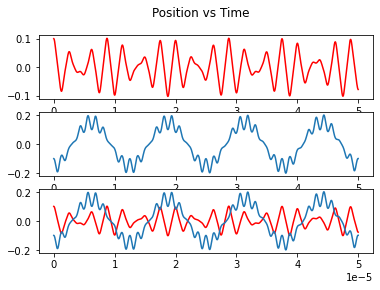

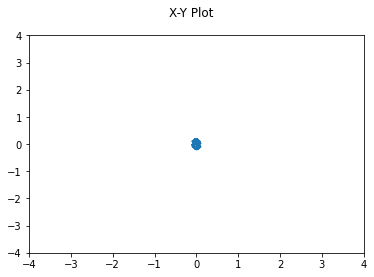

In [17]:
calculate_motion_runge_kutta(.1,-.1,.206,.706,400,.00000001,.00005,True,False,1.25)

# Plot Stability Diagram

#### scan_RF_DC - Parameters:

1. Starting RF
2. Ending RF
3. RF step
4. Starting DC
5. Ending DC
6. DC step
7. Mass charge ratio
8. Magnetic field (boolean) _default=False_
9. B (Magnetic field strength) _default=0_

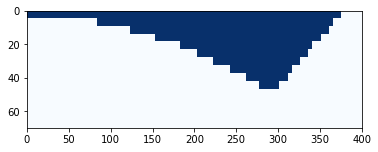

In [18]:
scan_RF_DC(0,400,5,0,70,5,400,False,1.8)